In [50]:
import numpy as np
from numba import jit

@jit(nopython=True)
def CEnergy(latt):
    "Energy of configuration for the 2D Ising model"
    N = np.shape(latt)[0]
    Ene = 0
    for i in range(len(latt)):
        for j in range(len(latt)):
            S = latt[i,j]   # Spin, can be either +1 or -1
            WF = latt[(i+1)%N,j]+latt[i,(j+1)%N]+latt[(i-1)%N,j]+latt[i,(j-1)%N]
            Ene += -S * WF
    return Ene/2.

def RandomL(N):
    "Random lattice corresponding to infinite temperature"
    return np.sign(2 * np.random.rand(N, N) - 1).astype(int)

In [51]:
def PrepareEnergies(N):
    Energies = (np.array(4*np.arange(-int(N*N/2),int(N*N/2)+1),dtype=int)).tolist() # -2 N^2...2N^2 in steps of 4
    #Energies = range(-2*N*N,2*N*N,4)
    Energies.pop(1)  # take out E[1]
    Energies.pop(-2) # take out E[-2]
    Energies = np.array(Energies) # make array of energies again
    Emin, Emax = Energies[0],Energies[-1]
    #index array to energies
    indE = -np.ones(Emax+1-Emin, dtype=int) # index table to get index to particular energy g(E)~g[indE[E]]
    for i,E in enumerate(Energies):
        indE[E-Emin]=i
    # Ising lattice at infinite T
    ## g(E) we know E = -2*N^2,2*N^2 in steps of 4...
    return (Energies, indE, Emin)

In [52]:
Ene,indE,Emin = PrepareEnergies(10)
print('Emin=',Emin)
print(Ene)
print(indE)

Emin= -200
[-200 -192 -188 -184 -180 -176 -172 -168 -164 -160 -156 -152 -148 -144
 -140 -136 -132 -128 -124 -120 -116 -112 -108 -104 -100  -96  -92  -88
  -84  -80  -76  -72  -68  -64  -60  -56  -52  -48  -44  -40  -36  -32
  -28  -24  -20  -16  -12   -8   -4    0    4    8   12   16   20   24
   28   32   36   40   44   48   52   56   60   64   68   72   76   80
   84   88   92   96  100  104  108  112  116  120  124  128  132  136
  140  144  148  152  156  160  164  168  172  176  180  184  188  192
  200]
[ 0 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1  2 -1 -1 -1  3 -1 -1 -1  4 -1 -1 -1
  5 -1 -1 -1  6 -1 -1 -1  7 -1 -1 -1  8 -1 -1 -1  9 -1 -1 -1 10 -1 -1 -1
 11 -1 -1 -1 12 -1 -1 -1 13 -1 -1 -1 14 -1 -1 -1 15 -1 -1 -1 16 -1 -1 -1
 17 -1 -1 -1 18 -1 -1 -1 19 -1 -1 -1 20 -1 -1 -1 21 -1 -1 -1 22 -1 -1 -1
 23 -1 -1 -1 24 -1 -1 -1 25 -1 -1 -1 26 -1 -1 -1 27 -1 -1 -1 28 -1 -1 -1
 29 -1 -1 -1 30 -1 -1 -1 31 -1 -1 -1 32 -1 -1 -1 33 -1 -1 -1 34 -1 -1 -1
 35 -1 -1 -1 36 -1 -1 -1 37 -1 -1 -1 38 -1 -1 -

In [53]:
from numpy import random
def WangLandau(Nitt, N, flatness):
    "Wang Landau in Python"
    (Energies, indE, Emin) = PrepareEnergies(N)
    latt = RandomL(N)

    lngE, Hist = RunWangLandau(Nitt, Energies, latt, indE)

    return lngE, Hist, Energies

In [54]:
@jit(nopython=True)
def RunWangLandau(Nitt,Energies,latt,indE):
    N   = len(latt)
    Ene = int(CEnergy(latt))
    #min,maximum energy
    Emin, Emax = Energies[0],Energies[-1]
    # Logarithm of the density of states
    lngE = np.zeros(len(Energies))
    # Histogram
    Hist = np.zeros(len(Energies))
    # modification factor
    lnf = 1.0   # f = exp(lnf)=e
    N2 = N*N
    for itt in range(Nitt):
        t = int(random.rand()*N2)
        (i, j) = (int(t/N), t%N)
        S = latt[i,j]
        WF = latt[(i+1)%N,j]+latt[i,(j+1)%N]+latt[(i-1)%N,j]+latt[i,(j-1)%N]
        Enew = Ene + int(2*S*WF) # the energy change if we flip the spin
        # P = g(E)/g(Enew) = exp(log(g(E))-log(g(Enew)))
        # P = exp(lngE(E)-lngE(Enew))
        lgnew = lngE[indE[Enew-Emin]] # log(g(Enew))
        lgold = lngE[indE[Ene-Emin]]  # log(g(Eold))
        P = 1.0
        if lgold-lgnew < 0 : P=np.exp(lgold-lgnew) # P = g_old/g_new = exp(log(g_old)-log(g_new))
        if P > random.rand():
            # accept the step
            latt[i,j] = -S
            Ene = Enew
        Hist[indE[Ene-Emin]] += 1
        lngE[indE[Ene-Emin]] += lnf   # g(E) -> g(E)*f hence log(g(E)) -> log(g(E))+log(f)
        
        if (itt+1) % 1000 == 0: # checking for flatness of the histogram
            aH = sum(Hist)/N2 # average
            mH = min(Hist)
            if mH > aH*flatness:  # histogram is flat
                Hist[:] = 0
                lnf /= 2.
                print(itt, 'histogram is flat', mH, aH, 'f=', np.exp(lnf))
    return (lngE, Hist)

In [56]:
flatness = 0.9
N = 32
Nitt = int(10e8)

#N=10
#Nitt = int(10e6)

(lngE, Hist, Energies) = WangLandau(Nitt, N, flatness)
print('Done')

67671999 histogram is flat 59557.0 66085.9375 f= 1.6487212707001282
81848999 histogram is flat 12461.0 13844.7265625 f= 1.2840254166877414
96031999 histogram is flat 12472.0 13850.5859375 f= 1.1331484530668263
114339999 histogram is flat 16095.0 17878.90625 f= 1.0644944589178593
131046999 histogram is flat 14698.0 16315.4296875 f= 1.0317434074991028
145899999 histogram is flat 13057.0 14504.8828125 f= 1.0157477085866857
163028999 histogram is flat 15083.0 16727.5390625 f= 1.007843097206448
178701999 histogram is flat 13784.0 15305.6640625 f= 1.0039138893383475
192654999 histogram is flat 12284.0 13625.9765625 f= 1.0019550335910028
216760999 histogram is flat 21249.0 23541.015625 f= 1.0009770394924165
248369999 histogram is flat 27819.0 30868.1640625 f= 1.0004884004786945
294130999 histogram is flat 40240.0 44688.4765625 f= 1.0002441704297478
365516999 histogram is flat 62791.0 69712.890625 f= 1.0001220777633837
488004999 histogram is flat 107792.0 119617.1875 f= 1.0000610370189331
5991

In [57]:
lngE[0],lngE[-1]

(np.float64(80390.022605896), np.float64(80389.22689819336))

In [58]:
# Proper normalization of the Density of states
# g *= 4/(g[0]+g[-1]) = 4/(g[-1]*(1+g[0]/g[-1]))
# g = g * 4/(g[-1]*(1+g[0]/g[-1]))
# log(g) = log(g) + log(4)-log(g[-1]) - log(1+g[0]/g[-1])
# log(g) += log(4)-log(g[-1])-log(1+exp(log(g[0])-log(g[-1])))
# 
if lngE[-1]>lngE[0]:
    lgC = np.log(4)-lngE[-1]-np.log(1+np.exp(lngE[0]-lngE[-1]))
else:
    lgC = np.log(4)-lngE[0]-np.log(1+np.exp(lngE[-1]-lngE[0]))

lngE += lgC

In [59]:
np.exp(lngE[0])+np.exp(lngE[-1]), np.exp(lngE[0]), np.exp(lngE[-1])  # g[0]+g[-1]

(np.float64(3.9999999999762132),
 np.float64(2.756222276809695),
 np.float64(1.2437777231665184))

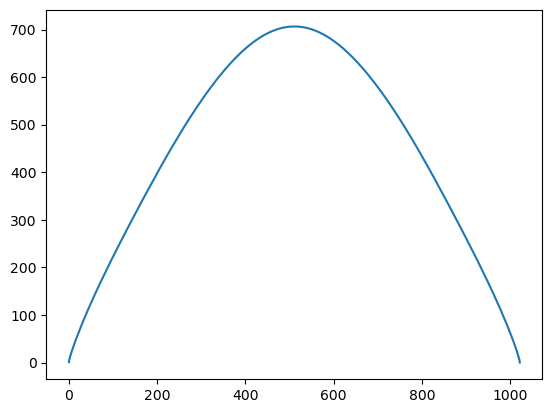

In [63]:
from pylab import *
%matplotlib inline

plot(lngE)

In [64]:
(Energies, indE, Emin) = PrepareEnergies(N)

def Thermod(T, lngE, Energies, N):
    Z = 0.
    Ev = 0.  # <E>
    E2v = 0. # <E^2>
    # <E^n> = sum_E e^(-E/T)*g[E] E^n /Z
    # Zw = Z/Z_0
    # <E^n> = Z0/Z sum_E e^(-(E-Emin)/T) g[E]/g[0] E^N
    for i,E in enumerate(Energies):
        # Z += exp(log(g)) * exp(-E/T)
        # Z/Z_0 = w where Z_0 = g[0] exp(-Energies[0]/T)
        w = np.exp(lngE[i]-lngE[0]-(E-Energies[0])/T) # g(E)/g0 Exp(-(E-E0)/T)
        Z += w
        Ev += w*E
        E2v += w*E**2
    Ev *= 1./Z
    E2v *= 1./Z
    cv = (E2v-Ev**2)/T**2
    # Z_correct = Z * exp(lngE[0]-Energies[0]/T)
    # Entropy = log(Z_correct) + <E>/T = log(Z) + lngE[0]-Energies[0]/T + Ev/T
    Entropy = np.log(Z)+lngE[0]+Ev/T-Energies[0]/T
    return (Ev/(N**2), cv/(N**2), Entropy/(N**2))

In [65]:
Te = np.linspace(0.5,4.,300)

Thm=[]
for T in Te:
    Thm.append(Thermod(T, lngE, Energies, N))
Thm = np.array(Thm)

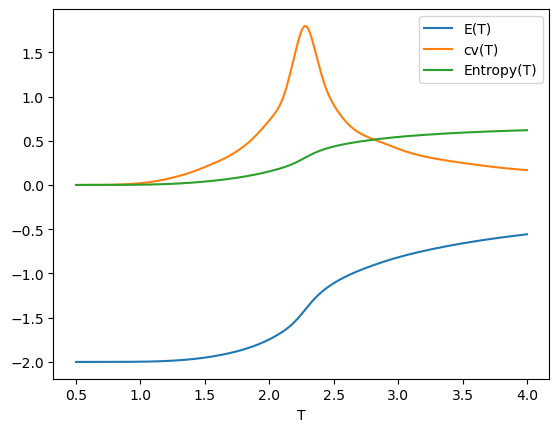

In [69]:
from pylab import *
%matplotlib inline

plot(Te, Thm[:,0], label='E(T)')
plot(Te, Thm[:,1], label='cv(T)')
plot(Te, Thm[:,2], label='Entropy(T)')
xlabel('T')
legend(loc='best')
show()

In [70]:
print('Entropy(T=%5.3f)=%8.6f Entropy(T=%5.3f)=%5.3f * log(2)' % (Te[0],Thm[0,2],Te[-1],Thm[-1,2]/np.log(2)))

Entropy(T=0.500)=0.000992 Entropy(T=4.000)=0.894 * log(2)


=== WL run 1/5 ===
=== WL run 2/5 ===
=== WL run 3/5 ===
=== WL run 4/5 ===
=== WL run 5/5 ===


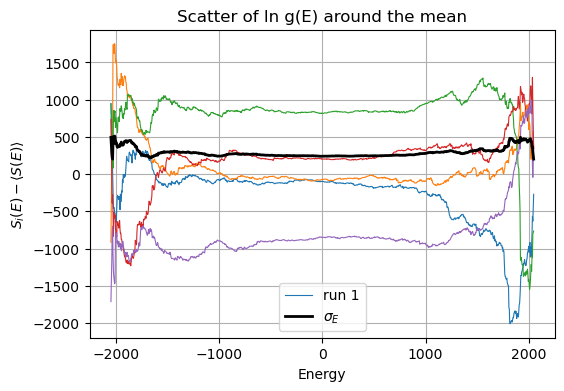

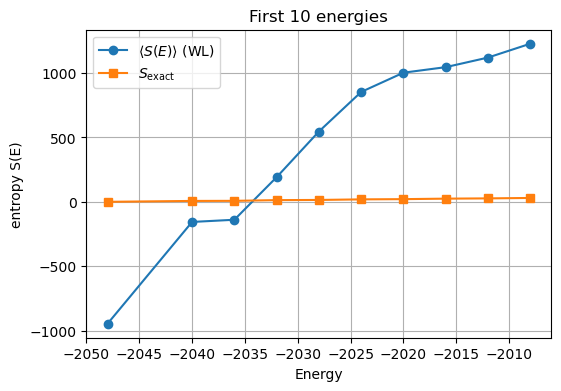

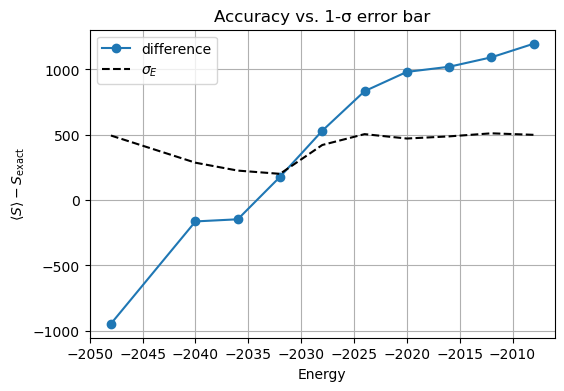

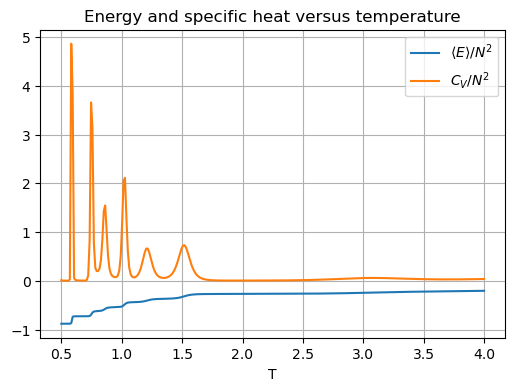

In [ ]:
# ---- User-tunable parameters -------------------------------------------------
N        = 32           # lattice size
Nitt     = int(1e7)     # <-- 1e9 in the assignment, but start small to test
runs     = 5            # independent WL simulations
flatness = 0.9
# -----------------------------------------------------------------------------

all_lngE = []           # store each run’s ln g(E)
for r in range(runs):
    print(f'=== WL run {r+1}/{runs} ===')
    lngE, Hist, Energies = WangLandau(Nitt, N, flatness)

    # --- normalise: g_min + g_max = 4  (same trick as in the notebook)
    if lngE[-1] > lngE[0]:
        lgC = np.log(4) - lngE[-1] - np.log(1 + np.exp(lngE[0] - lngE[-1]))
    else:
        lgC = np.log(4) - lngE[0] - np.log(1 + np.exp(lngE[-1] - lngE[0]))
    lngE += lgC
    all_lngE.append(lngE)

all_lngE = np.array(all_lngE)              # shape (runs, nE)

def Thermod(T, Sln, Energies, N):
    """
    Canonical ⟨E⟩ and C_V from ln g(E) at temperature T.
    Returns per-spin values (divide by N*N).
    """
    beta = 1.0 / T
    x = Sln - beta * Energies          # exponent arguments

    # --- log-sum-exp to avoid overflow ---------------------
    x_max = x.max()
    w = np.exp(x - x_max)              #  all w  <=  1 now
    Z = w.sum()
    lnZ = x_max + np.log(Z)

    E_mean  = (Energies * w).sum() / Z
    E2_mean = (Energies**2 * w).sum() / Z
    Cv      = beta**2 * (E2_mean - E_mean**2)

    return E_mean / (N*N), Cv / (N*N)

# -----------------------------------------------------------------------------#
# 1.  <S(E)> and statistical error sigma_E
# -----------------------------------------------------------------------------#
S_mean  = all_lngE.mean(axis=0)
S_sigma = all_lngE.std(axis=0, ddof=0) / np.sqrt(runs)   # formula in assignment

figure(figsize=(6,4))
for i in range(runs):
    plot(Energies, all_lngE[i] - S_mean, lw=0.8,
         label=f'run {i+1}' if i==0 else None)
plot(Energies, S_sigma, 'k', lw=2, label=r'$\sigma_E$')
xlabel('Energy'); ylabel(r'$S_i(E)-\langle S(E)\rangle$')
legend(); grid(True)
title('Scatter of ln g(E) around the mean')
show()

# -----------------------------------------------------------------------------#
# 2.  Compare with exact DOS for the first 10 energies
# -----------------------------------------------------------------------------#
g_exact = np.array([2,2048,4096,1057792,4218880,
                 371621888,2191790080,100903637504,
                 768629792768,22748079183872], dtype=float)
S_exact = np.log(g_exact)

# Find the indices of the 10 lowest energies in the 32×32 list
# idx10 = [np.where(Energies == 4*e)[0][0] for e in range(-N*N//2, -N*N//2+10)]
idx10 = np.arange(100)
E10   = Energies[idx10]

figure(figsize=(6,4))
plot(E10, S_mean[idx10], 'o-', label=r'$\langle S(E)\rangle$ (WL)')
plot(E10, S_exact,       's-', label=r'$S_{\mathrm{exact}}$')
xlabel('Energy'); ylabel('entropy S(E)')
legend(); grid(True); title('First 10 energies')
show()

figure(figsize=(6,4))
plot(E10, S_mean[idx10]-S_exact, 'o-', label='difference')
plot(E10, S_sigma[idx10],        'k--', label=r'$\sigma_E$')
xlabel('Energy'); ylabel(r'$\langle S\rangle - S_{\mathrm{exact}}$')
legend(); grid(True)
title('Accuracy vs. 1-σ error bar')
show()

# -----------------------------------------------------------------------------#
# 3.  Thermodynamics from the best DOS estimate
# -----------------------------------------------------------------------------#
# (Use the average; alternatively pick the run with the flattest final histogram.)
Te   = np.linspace(0.5, 4.0, 300)
Thm  = np.array([Thermod(T, S_mean, Energies, N) for T in Te])



figure(figsize=(6,4))
plot(Te, Thm[:,0], label=r'$\langle E\rangle/N^2$')
plot(Te, Thm[:,1], label=r'$C_V/N^2$')
xlabel('T'); legend(); grid(True)
title('Energy and specific heat versus temperature')
show()
